# Loan Default Prediction
This notebook runs the data preparation, exploratory data analysis (EDA), feature engineering, training, and basic evaluation. 

## 1) Environment and setup
Activate your conda env in Command Prompt (cmd.exe):

```bash
conda activate snow
pip install mlflow   # only if not installed already
cd C:\Users\jaeck\Github\Loan-Default-Prediction

:: start mlflow server (file/sqlite backend + local mlruns artifact dir)
mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 0.0.0.0 --port 5000

```


In [2]:
# Imports and basic configs
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Python', os.sys.version)
ROOT = Path('..') if Path('src').exists() else Path('.')
PROC = Path('../src/data/processed/loan.csv')
print('Processed CSV path:', PROC.resolve())


Python 3.13.7 | packaged by Anaconda, Inc. | (main, Sep  9 2025, 19:54:37) [MSC v.1929 64 bit (AMD64)]
Processed CSV path: C:\Users\jaeck\Github\Loan-Default-Prediction\src\data\processed\loan.csv


In [3]:
# Load processed CSV
if not PROC.exists():
    print('Processed CSV not found. Run: python src/data/prepare.py')
else:
    df = pd.read_csv(PROC)
    print('Loaded processed dataframe with shape:', df.shape)
    display(df.head())


Loaded processed dataframe with shape: (121856, 13)


,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,target
0,0.0,0.0,1.0,0.0,0.0,9.0,1,1,0,2.0,2.0,6.0,0
1,1.0,0.0,1.0,1.0,0.0,0.0,1,0,1,2.0,2.0,3.0,0
2,0.0,0.0,1.0,0.0,1.0,9.0,1,0,0,2.0,2.0,4.0,0
3,0.0,0.0,1.0,1.0,0.0,9.0,1,0,0,2.0,3.0,2.0,0
4,1.0,0.0,1.0,0.0,2.0,6.0,1,0,0,4.0,1.0,3.0,0


## 2) Quick EDA

Target value counts:
target
0    112011
1      9845
Name: count, dtype: int64


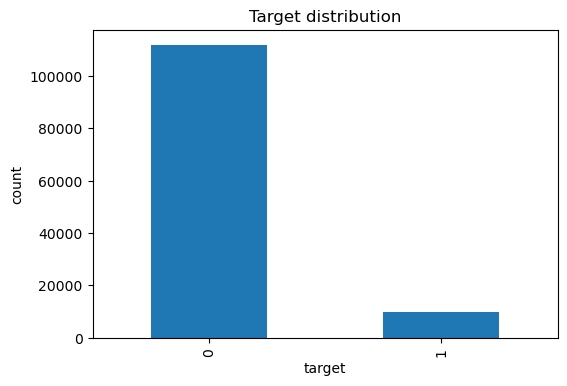

,count,mean,std,min,25%,50%,75%,max
Car_Owned,121856.0,0.332778,0.471210,0.0,0.0,0.0,1.0,1.0
Bike_Owned,121856.0,0.322381,0.467390,0.0,0.0,0.0,1.0,1.0
Active_Loan,121856.0,0.484285,0.499755,0.0,0.0,0.0,1.0,1.0
House_Own,121856.0,0.701311,0.457685,0.0,0.0,1.0,1.0,1.0
Child_Count,121856.0,0.405306,0.721353,0.0,0.0,0.0,1.0,19.0
Own_House_Age,121856.0,10.082039,7.215055,0.0,9.0,9.0,9.0,69.0
Mobile_Tag,121856.0,0.999992,0.002865,0.0,1.0,1.0,1.0,1.0
Homephone_Tag,121856.0,0.200499,0.400375,0.0,0.0,0.0,0.0,1.0
Workphone_Working,121856.0,0.281201,0.449587,0.0,0.0,0.0,1.0,1.0
Client_Family_Members,121856.0,2.151277,0.903871,1.0,2.0,2.0,3.0,16.0


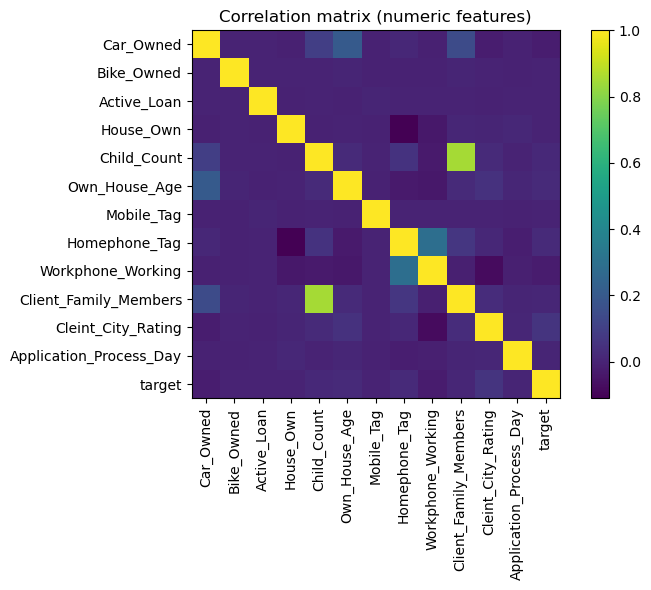

In [4]:
if 'df' in globals():
    # Target distribution
    print('Target value counts:')
    print(df['target'].value_counts(dropna=False))
    plt.figure(figsize=(6,4))
    df['target'].value_counts().plot(kind='bar')
    plt.title('Target distribution')
    plt.xlabel('target')
    plt.ylabel('count')
    plt.show()
    # Numeric summary
    display(df.describe().T)
    # Correlation heatmap for numeric features
    num = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num) > 1:
        import matplotlib
        plt.figure(figsize=(8,6))
        corr = df[num].corr()
        plt.imshow(corr, interpolation='nearest')
        plt.xticks(range(len(corr)), corr.columns, rotation=90)
        plt.yticks(range(len(corr)), corr.columns)
        plt.colorbar()
        plt.title('Correlation matrix (numeric features)')
        plt.tight_layout()
        plt.show()


## 3) Feature / Label split and simple preprocessing

In [5]:
if 'df' in globals():
    # Prepare X, y
    y = df['target'].astype(int)
    X = df.drop(columns=['target']).copy()
    # Keep numeric only for this notebook (fast path)
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    print('Numeric cols used:', numeric_cols)
    X_num = X[numeric_cols].fillna(X[numeric_cols].median())
    display(X_num.head())


Numeric cols used: ['Car_Owned', 'Bike_Owned', 'Active_Loan', 'House_Own', 'Child_Count', 'Own_House_Age', 'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working', 'Client_Family_Members', 'Cleint_City_Rating', 'Application_Process_Day']


,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Cleint_City_Rating,Application_Process_Day
0,0.0,0.0,1.0,0.0,0.0,9.0,1,1,0,2.0,2.0,6.0
1,1.0,0.0,1.0,1.0,0.0,0.0,1,0,1,2.0,2.0,3.0
2,0.0,0.0,1.0,0.0,1.0,9.0,1,0,0,2.0,2.0,4.0
3,0.0,0.0,1.0,1.0,0.0,9.0,1,0,0,2.0,3.0,2.0
4,1.0,0.0,1.0,0.0,2.0,6.0,1,0,0,4.0,1.0,3.0


## 4) Train / Evaluate baseline models (Logistic + Random Forest)

In [6]:
if 'X_num' in globals():
    X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=42, stratify=y)
    print('Train/test shapes:', X_train.shape, X_test.shape)
    # Logistic Regression
    lr = LogisticRegression(max_iter=500)
    lr.fit(X_train, y_train)
    p_lr = lr.predict_proba(X_test)[:,1]
    pred_lr = (p_lr >= 0.5).astype(int)
    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    p_rf = rf.predict_proba(X_test)[:,1]
    pred_rf = (p_rf >= 0.5).astype(int)
    def metrics(y_true, y_pred_prob, y_pred):
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'roc_auc': roc_auc_score(y_true, y_pred_prob) if len(set(y_true))>1 else None,
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0)
        }
    res_lr = metrics(y_test, p_lr, pred_lr)
    res_rf = metrics(y_test, p_rf, pred_rf)
    print('Logistic:', res_lr)
    print('RandomForest:', res_rf)


Train/test shapes: (97484, 12) (24372, 12)
Logistic: {'accuracy': 0.9191695388150336, 'roc_auc': 0.5826936835325077, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
RandomForest: {'accuracy': 0.9146151321188248, 'roc_auc': 0.5781441110139356, 'precision': 0.28125, 'recall': 0.036566785170137124, 'f1': 0.06471910112359551}


## 5) Cross-validation and feature importance (Random Forest)

CV ROC AUC (3-fold): [0.56664844 0.57904843 0.57215952]


Own_House_Age              0.339678
Application_Process_Day    0.261405
Client_Family_Members      0.086206
Active_Loan                0.054283
Bike_Owned                 0.050697
Child_Count                0.048998
House_Own                  0.047720
Cleint_City_Rating         0.040844
Workphone_Working          0.027222
Homephone_Tag              0.025313
Car_Owned                  0.017620
Mobile_Tag                 0.000014
dtype: float64

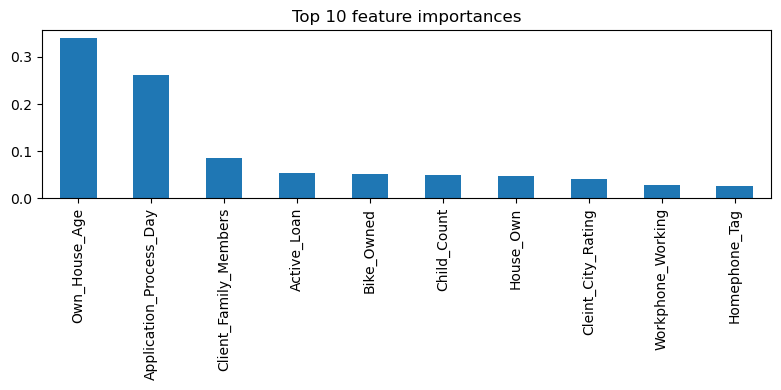

In [7]:
if 'rf' in globals():
    scores = cross_val_score(rf, X_num, y, cv=3, scoring='roc_auc') if len(set(y))>1 else None
    print('CV ROC AUC (3-fold):', scores)
    # Feature importance
    try:
        importances = rf.feature_importances_
        fi = pd.Series(importances, index=X_num.columns).sort_values(ascending=False)
        display(fi.head(20))
        plt.figure(figsize=(8,4))
        fi.head(10).plot.bar()
        plt.title('Top 10 feature importances')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Could not compute feature importances:', e)


## 6) Save model & (optional) log to MLflow

In [12]:
import joblib
MODEL_DIR = Path('../src/models') if Path('../src/models').exists() else Path('../src/models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
model_file = MODEL_DIR / 'model_rf.pkl'
joblib.dump(rf, model_file)
print('Saved RandomForest to', model_file.resolve())
# Optional MLflow logging
try:
    import mlflow, mlflow.sklearn, time
    mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_URI', 'http://localhost:5000'))
    # Set or create experiment (creates if doesn't exist)
    mlflow.set_experiment('loan_default_prediction')
    with mlflow.start_run(run_name='notebook_run_'+time.strftime('%Y%m%d-%H%M%S')) as run:
        mlflow.log_params({'n_features': X_num.shape[1]})
        for k,v in res_rf.items():
            if v is not None:
                mlflow.log_metric('rf_'+k, float(v))
        mlflow.sklearn.log_model(rf, 'model_rf')
    print('Logged run to MLflow at', mlflow.get_tracking_uri())
except Exception as e:
    print('MLflow not available or failed to log:', e)


Saved RandomForest to C:\Users\jaeck\Github\Loan-Default-Prediction\src\models\model_rf.pkl


2025/12/07 19:44:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run notebook_run_20251207-194424 at: http://localhost:5000/#/experiments/879207056872367505/runs/30ccadbde92d4009b39470a303455aa7
🧪 View experiment at: http://localhost:5000/#/experiments/879207056872367505
Logged run to MLflow at http://localhost:5000


## 7) Quick smoke test of the FastAPI predict endpoint (if app running)

In [17]:
import requests, json
if model_file.exists():
    print('Model file present:', model_file)
else:
    print('Model file missing; build and run app container or run uvicorn manually')
ALB = 'http://localhost:8000'
try:
    resp = requests.get(ALB + '/health', timeout=3)
    print('App health:', resp.json())
    # build a sample payload using median values for ALL features (model expects all columns)
    sample = {c: float(X_num[c].median()) for c in X_num.columns}
    print(f'\n=== EXACT SAMPLE USED FOR SMOKE TEST ===')
    print(f'Number of features: {len(sample)}')
    print(f'\nFeature values (median):')
    for feature_name, feature_value in sorted(sample.items()):
        print(f'  {feature_name}: {feature_value}')
    print(f'\nJSON payload:')
    print(json.dumps({'features': sample}, indent=2))
    print(f'==========================================\n')
    print(f'Sending {len(sample)} features to predict endpoint...')
    pred = requests.post(ALB + '/predict', json={'features': sample}, timeout=10)
    print('Predict response:', pred.json())
except Exception as e:
    print('App not reachable at', ALB, '; error:', e)


Model file present: ..\src\models\model_rf.pkl
App health: {'status': 'ok'}

=== EXACT SAMPLE USED FOR SMOKE TEST ===
Number of features: 12

Feature values (median):
  Active_Loan: 0.0
  Application_Process_Day: 3.0
  Bike_Owned: 0.0
  Car_Owned: 0.0
  Child_Count: 0.0
  Cleint_City_Rating: 2.0
  Client_Family_Members: 2.0
  Homephone_Tag: 0.0
  House_Own: 1.0
  Mobile_Tag: 1.0
  Own_House_Age: 9.0
  Workphone_Working: 0.0

JSON payload:
{
  "features": {
    "Car_Owned": 0.0,
    "Bike_Owned": 0.0,
    "Active_Loan": 0.0,
    "House_Own": 1.0,
    "Child_Count": 0.0,
    "Own_House_Age": 9.0,
    "Mobile_Tag": 1.0,
    "Homephone_Tag": 0.0,
    "Workphone_Working": 0.0,
    "Client_Family_Members": 2.0,
    "Cleint_City_Rating": 2.0,
    "Application_Process_Day": 3.0
  }
}

Sending 12 features to predict endpoint...
Predict response: {'predictions': [0]}
